# Automatic night input

This script lets you set the night in the database automatically. It uses the light sensor data to compute it.

If first shows the day/night graph and corresponding date/time and asks for confirmation on the value found.

| ![](../images/autonight.jpg) | 
|:--:| 
|Example of graph obtained with autonight. At the beginning of the experiment one can see the high lights while the experiment is starting, then the plateau when lights are on, and the 2nd plateau representing the night, and again on light phase **horizontal red line**:automatic threshold on light value. **pink zone**: dark phases found automatically, **gray zone (surimposed on pink in this example)**: dark phases previously existing in the sequence |

Code launched.
Processing file D:/usv_shank3/20191014_usv_lmt_pair_shank3_4849144_4849294/20191014_usv_lmt_pair_shank3_4849144_4849294.sqlite
--------------
Current file:  D:/usv_shank3/20191014_usv_lmt_pair_shank3_4849144_4849294/20191014_usv_lmt_pair_shank3_4849144_4849294.sqlite
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 3  records loaded in  20.71875500679016 S )
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME', 'AGE', 'SEX', 'STRAIN']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE,AGE,SEX,STRAIN FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849294 Genotype:KO User1:None
Animal Id:2 Name:B RFID:000004849144 Genotype:KO User1:None
plotting sensor data.  LIGHTVISIBLEANDIR
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 3  records loaded in  3.078157663345337 S )
Skipping very short night phase. (less than 10 seconds)
Saving figure : D:/usv_shank3/20191014_usv_lmt_pair_shank3_48

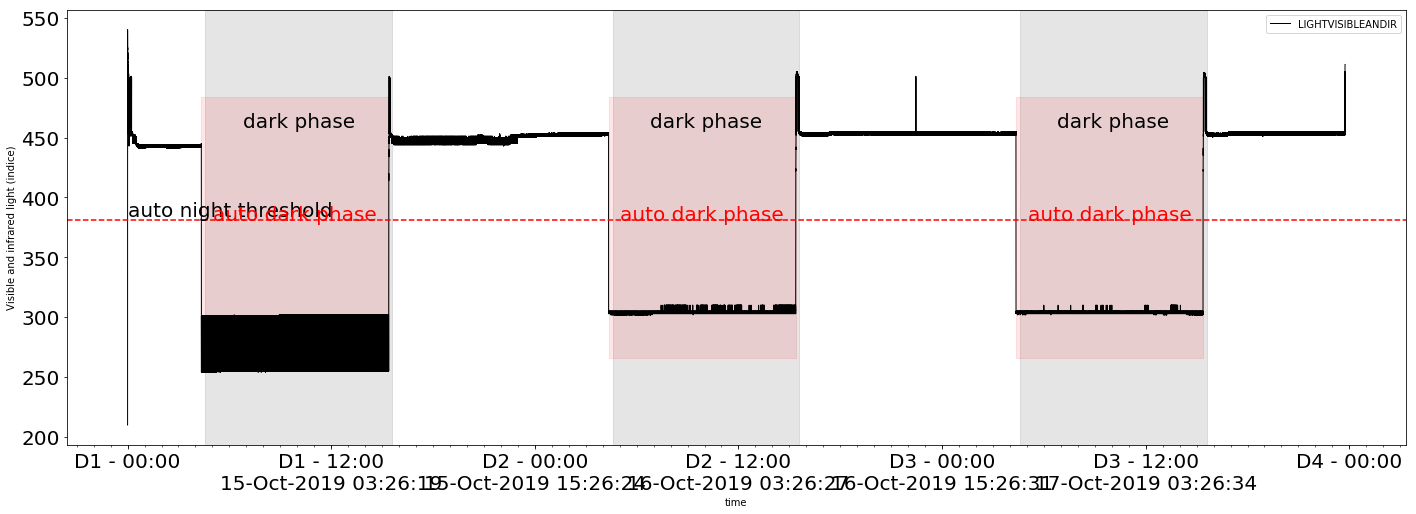

Night # 1
Starts at  14-10 (Oct)-2019 19:47:01
Ends at  15-10 (Oct)-2019 06:49:45
Night # 2
Starts at  15-10 (Oct)-2019 19:47:11
Ends at  16-10 (Oct)-2019 06:49:11
Night # 3
Starts at  16-10 (Oct)-2019 19:47:57
Ends at  17-10 (Oct)-2019 06:49:32


In [ ]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from tkinter.filedialog import askopenfilename
import sys
from lmtanalysis.FileUtil import getFilesToProcess

class FileProcessException(Exception):
    pass

def getDateTime( animalPool, frame ):

    if frame > 0:
        
        datetime = getDatetimeFromFrame( animalPool.conn , frame )
        if datetime != None:
            realTime = getDatetimeFromFrame( animalPool.conn , frame ).strftime('%d-%m (%b)-%Y %H:%M:%S')
            return realTime
    return None


def process( file ):
    
    connection = sqlite3.connect( file )     

    print( "--------------")
    print( "Current file: ", file )
    
    nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )
    nightTimeLine.eventList.clear()
    
    connection = sqlite3.connect( file )
    # build sensor data
    animalPool = AnimalPool( )
    animalPool.loadAnimals( connection )
    autoNightList = animalPool.plotSensorData( 
        sensor = "LIGHTVISIBLEANDIR" , minValue = 40 , saveFile = file+"_log_light visible.pdf", show = True, autoNight = True  )
    
    # show nights 
    
    nightNumber = 1

    if autoNightList == None:
        print("No sensor data found.")
        return
        
    for autoNight in autoNightList:
    
        print( "Night #" , str( nightNumber ) )
        print( "Starts at " , getDateTime( animalPool , autoNight[0] ) )
        print( "Ends at " , getDateTime( animalPool, autoNight[1]) )
        
        nightNumber+=1
    
    # ask confirmation
        
    answer = input ("Set night(s) with autoNight data ? [Y/N]:")
    if answer.lower() == "y":
        print("Setting events...")
        
        nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )        
        nightTimeLine.eventList.clear()
              
        for autoNight in autoNightList:
            nightTimeLine.addEvent( Event( autoNight[0], autoNight[1] ) )
              
        nightTimeLine.endRebuildEventTimeLine(connection, deleteExistingEvent = True  )
        print("Setting events... Done")
    else:
        print("autoNight canceled.")
    
print("Code launched.")

files = getFilesToProcess()

if ( files != None ):

    for file in files:
        try:
            print ( "Processing file" , file )
            process( file )
        except FileProcessException:
            print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )

print( "*** ALL JOBS DONE ***")